In [62]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import sys
sys.path.append('../')
from comparisons.buy_and_hold import Strategy_Comparison
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
# Function computes a Linear Regression line to fit the data based on the previous 'scope' data points. It outputs True
# if the current price is n below the Linear Regression line
        
def tilted_mean(data, scope, n, check = 'buy'):
    actual_prices = data[-scope:]
    data_points = np.arange(scope).reshape(-1,1)
    model = LinearRegression().fit(data_points, actual_prices)
    predicted_prices = model.predict(data_points)
    current_predicted_price = model.predict([[scope - 1]])[0][0] # What you would expect the current price to be based off of trends
    residuals = actual_prices - predicted_prices
    stddev = residuals.std().iloc[0]
    #print(type(stddev),type(current_predicted_price),type(n),type(data.iloc[-1]))
    if check == 'buy':
        return data.iloc[-1].iloc[0] < (current_predicted_price - n * stddev)

    else:
        return data.iloc[-1].iloc[0] > (current_predicted_price + n * stddev)


class MeanReversion(Strategy_Comparison):

    def tilted_mean_reversion(self, period, scope = 30, graph = True, analysis = True):
        period = self.default_period(period)
        segment = self.data.loc[period[0] : period[1]]

        
        '''
            The Strategies Logic
        '''

        
        investment = period[2]
        strat_investment = [ investment ]
        position = False
        time_in_market = 0

        # Loop over every data point once there is enough data to analyse previous data
        for i in range(scope, len(segment)):
            if position:
                time_in_market += 1
                perc_change = segment.iloc[i] / segment.iloc[i - 1]
                investment *= perc_change.iloc[0] # Increase investment if we are in the market
                strat_investment.append(investment) 
                # If we go above 2std above the mean, sell
                if tilted_mean(segment.iloc[i - scope : i], scope, 2, check = 'sell'):
                #if segment.iloc[i].iloc[0] > segment.iloc[i - scope : i].mean().iloc[0] + 2 * np.sqrt(segment.iloc[i - scope : i].var().iloc[0]):
                    position = False
            else:
                strat_investment.append(0) # If we're not in the market, append 0 to investment amount
                
            if not position and tilted_mean(segment.iloc[i - scope : i], scope, 2, check = 'buy'):
            # if not position and segment.iloc[i].iloc[0] < segment.iloc[i - scope : i].mean().iloc[0] - 2 * np.sqrt(segment.iloc[i - scope : i].var().iloc[0]):
                position = True # if we are not in the market and the price is below 2std below the mean -> buy



        results = {
            'strat_returns' : investment,
            'strat_array_returns' : strat_investment,
            'time_in_market' : time_in_market,
        }

        return self.strategy_template(results, period = period, scope = scope, graph = graph, analysis = analysis)

In [104]:
msft = MeanReversion('MSFT')
msft.data

[*********************100%%**********************]  1 of 1 completed


,MSFT
Date,
1986-03-13,0.060163
1986-03-14,0.062311
1986-03-17,0.063386
1986-03-18,0.061774
1986-03-19,0.060700
...,...
2024-02-21,402.179993
2024-02-22,411.649994
2024-02-23,410.339996


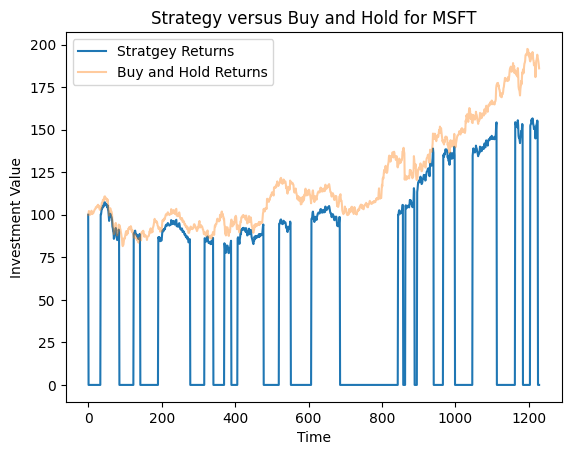

Initial Investment: 100 
Buy and Hold Returns: 186.01   Percentage Increase:  86.01 % 
Strategy Returns: 154.37       Percentage Increase:  54.37 %  Risk-Adjusted Returns: 110.54 %


[186.01, 86.01, 154.37, 54.37, 110.54]

In [105]:
period = ['2010-01-01', '2015-01-01', 100]
msft.tilted_mean_reversion(period, scope = 30)

[*********************100%%**********************]  1 of 1 completed


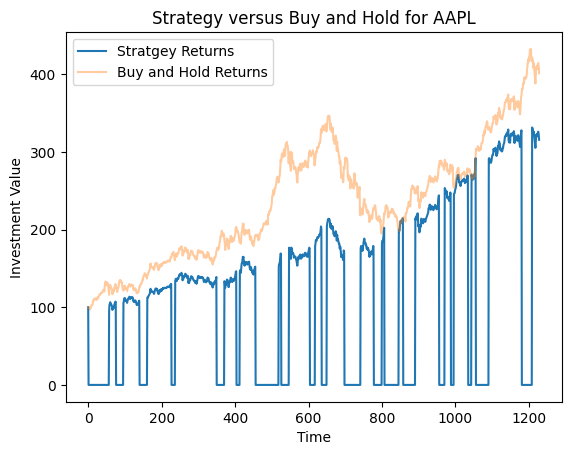

Initial Investment: 100 
Buy and Hold Returns: 401.14   Percentage Increase:  301.14 % 
Strategy Returns: 315.52       Percentage Increase:  215.52 %  Risk-Adjusted Returns: 354.77 %


[401.14, 301.14, 315.52, 215.52, 354.77]

In [98]:
aapl = MeanReversion('AAPL')
aapl.tilted_mean_reversion(period, scope = 30)

### Using Linear Regression to plot a linear model of the trend of the previous 'scope' data points, and triggering buy signals when the stock price falls significantly below these trends has made an apparent (further analysis needs to be done) massive improvement to the strategy.